In [1]:
import util_funs.globalsettings as gs
from langchain.agents import create_csv_agent
from langchain.llms import OpenAI

from langchain.vectorstores.chroma import Chroma
from langchain.chat_models import ChatOpenAI
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.chains import ConversationalRetrievalChain
from langchain.chains.question_answering import load_qa_chain
from langchain.schema import HumanMessage, AIMessage

from langchain.agents import AgentType, initialize_agent

from langchain import LLMMathChain, SerpAPIWrapper
from langchain.tools import BaseTool, StructuredTool, Tool, tool

from langchain.memory import ConversationBufferMemory, ConversationSummaryBufferMemory

from langchain import PromptTemplate

from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    HumanMessagePromptTemplate,
)

import matplotlib.pyplot as plt

Could not import azure.core python package.
c:\Users\migue\Documents\PROYECTOS DATA SCIENCE\langchain\.venv\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\migue\Documents\PROYECTOS DATA SCIENCE\langchain\.venv\Lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\migue\Documents\PROYECTOS DATA SCIENCE\langchain\.venv\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Chat Model

In [2]:
model = ChatOpenAI(
        model_name="gpt-3.5-turbo",
        temperature="0",
        # verbose=True
    )

# CSV Agent

In [3]:
agent_spain = create_csv_agent(model, gs.the_files.CSV_FILES[0], verbose=True)
agent_ue    = create_csv_agent(model, gs.the_files.CSV_FILES[1], verbose=True)

# Q&A Chain for PDFs

In [4]:
# system_prompt = PromptTemplate(
#     template = """
# Eres un experto en macroeconomía nacional. 
# Tu trabajo es contestar una pregunta sobre la situación económica
# de España en 2022. Debes contestar siempre en español.
# PREGUNTA:  
#               """,
#     input_variables = [],
# )

# system_message_prompt = SystemMessagePromptTemplate(prompt=system_prompt)

# human_prompt=PromptTemplate(
#     template="{text}",
#     input_variables=["text"]
# )

# human_message_prompt = HumanMessagePromptTemplate(prompt=human_prompt)

# chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt, human_message_prompt])

chat_prompt = PromptTemplate(
    template="""
Contesta en español la siguiente pregunta.
PREGUNTA:  {text}
""",
    input_variables=["text"]
)

In [5]:
chat_prompt.format(text="Cuál fue la tasa de paro total en España en 2023T1?")

'\nContesta en español la siguiente pregunta.\nPREGUNTA:  Cuál fue la tasa de paro total en España en 2023T1?\n'

In [6]:
# system_prompt.format_prompt().to_messages()

In [7]:
vector_store_pdf = Chroma(
    collection_name='pdf_files',
    embedding_function=OpenAIEmbeddings(),
    persist_directory=gs.the_folders.DIR_PERSIST
    )
pdf_retriever = vector_store_pdf.as_retriever()

memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

qa_chain = ConversationalRetrievalChain.from_llm(
    model,
    retriever=pdf_retriever,
    return_source_documents=False,
    # memory =  memory
    # verbose=True,
    )

Using embedded DuckDB with persistence: data will be stored in: C:\Users\migue\Documents\PROYECTOS DATA SCIENCE\langchain\PYTHON\util_funs\..\..\data\chroma


In [8]:
qa_chain({"question": "Cuáles fueron las consecuencias de la guerra de Ucrania? Contesta en español", 'chat_history': []})

{'question': 'Cuáles fueron las consecuencias de la guerra de Ucrania? Contesta en español',
 'chat_history': [],
 'answer': 'Una de las consecuencias de la guerra de Ucrania fue la prolongación de las tensiones en los mercados de materias primas, especialmente en los energéticos, lo que aumentó la probabilidad de efectos de segunda ronda en los precios. Los mercados de materias primas, especialmente los energéticos y alimentarios, sufrieron notables alzas desde el inicio de la guerra debido a la dependencia global de la oferta proveniente de Rusia y Ucrania. La persistencia de tensiones en los precios de las materias primas siguió presionando las tasas de inflación al alza, haciendo más probable la materialización de efectos de segunda ronda. El gas natural fue la materia prima más afectada, especialmente si se materializaba un corte de suministro desde Rusia hacia Europa. Una interrupción total del suministro de gas natural desde Rusia tendría un impacto significativo en la oferta di

In [9]:
qa_chain({"question": chat_prompt.format(text="Qué dos importantes paquetes de respuesta a las consecuencias económicas y sociales de la guerra de Ucrania se han adoptado"),
          'chat_history': []})

{'question': '\nContesta en español la siguiente pregunta.\nPREGUNTA:  Qué dos importantes paquetes de respuesta a las consecuencias económicas y sociales de la guerra de Ucrania se han adoptado\n',
 'chat_history': [],
 'answer': 'En el curso de 2022 se han adoptado dos importantes paquetes de respuesta a las consecuencias económicas y sociales de la guerra de Ucrania. El primer paquete de medidas fue adoptado en marzo y permitió una reducción de la tasa de IPC interanual de 1,5 puntos, hasta situarla en el 8,3% en abril. El segundo paquete de medidas fue adoptado en junio y se prevé una reducción del IPC superior a los 3,5 puntos porcentuales.'}

# IF-PROMPT

In [10]:
the_template="""
Tu trabajo es clasificar una pregunta. 
Estas son tus INSTRUCCIONES para clasificar la pregunta:
- Si tiene que ver con el paro / desempleo en España (por ejemplo: 'Cuál fue  
la tasa de paro total en España en 2023T1?'), contestarás
con la palabra: 'csv_spain_retriever'  
- Si tiene que ver con el paro / desempleo en la Unión Europea (UE)
(por ejemplo, 'cual fue la tasa de desempleo en la UE en 2021?'),
contestarás con la palabra 'csv_ue_retriever'
- Si no es ninguno de los casos anteriores o no sabes la respuesta contestarás
con la palabra 'pdf_retriever'
PREGUNTA:  {query}
"""    

if_prompt = PromptTemplate(
    input_variables=["query"], 
    template=the_template          
)

In [11]:
if_prompt.format(query = "Cuál fue la tasa de paro total en España en 2023T1?")

"\nTu trabajo es clasificar una pregunta. \nEstas son tus INSTRUCCIONES para clasificar la pregunta:\n- Si tiene que ver con el paro / desempleo en España (por ejemplo: 'Cuál fue  \nla tasa de paro total en España en 2023T1?'), contestarás\ncon la palabra: 'csv_spain_retriever'  \n- Si tiene que ver con el paro / desempleo en la Unión Europea (UE)\n(por ejemplo, 'cual fue la tasa de desempleo en la UE en 2021?'),\ncontestarás con la palabra 'csv_ue_retriever'\n- Si no es ninguno de los casos anteriores o no sabes la respuesta contestarás\ncon la palabra 'pdf_retriever'\nPREGUNTA:  Cuál fue la tasa de paro total en España en 2023T1?\n"

In [12]:
from langchain.llms import OpenAI
llm = OpenAI()
llm(if_prompt.format(query = "Cuál fue la tasa de paro total en España en 2023T1?"))

'RESPUESTA: csv_spain_retriever'

In [13]:
llm(if_prompt.format(query = "Cuáles fueron las consecuencias de la guerra de Ucrania?"))

'RESPUESTA: pdf_retriever'

In [14]:
llm(if_prompt.format(query = "Cómo evoluciono el paro en la UE?"))

'\nRESPUESTA: csv_ue_retriever'

# Test framework

In [15]:
def ask_if_prompt(the_query):
    
    res = llm(if_prompt.format(query = the_query))

    if ('spain' in res):
       # print("SPAIN - " + the_query)
       out = agent_spain.run(chat_prompt.format(text=the_query))
    elif ('ue' in res):
       # print("UE - " + the_query)
       out = agent_ue.run(chat_prompt.format(text=the_query))
    else:
        # print("PDF - " + the_query)
      #   out = qa_chain({"question": the_query, 'chat_history': []})['answer']
      #   out = qa_chain(chat_prompt.format(text=the_query))['answer']
      out = qa_chain({"question": chat_prompt.format(text=the_query),
                      'chat_history': []})['answer']    
    return out

In [16]:
ask_if_prompt(the_query = "Cuáles fueron las consecuencias de la guerra de Ucrania?")

'Según el texto proporcionado, una de las consecuencias de la guerra de Ucrania fue el aumento de las tensiones en los mercados de materias primas, especialmente en los energéticos, lo que provocó un aumento en los precios de estas materias primas. Esto se debió a la dependencia global de la oferta proveniente de Rusia y Ucrania. El gas natural fue la materia prima más afectada y sufriría aún más si se materializara un corte de suministro desde Rusia hacia Europa. Además, la persistencia de tensiones en los precios de materias primas seguiría presionando las tasas de inflación al alza, haciendo más probable la materialización de efectos de segunda ronda.'

In [17]:
ask_if_prompt(the_query = "Cuál fue la tasa de paro total en España en 2023T1?")



> Entering new AgentExecutor chain...
Thought: Necesito filtrar los datos para obtener la fila correspondiente a 2023T1 y luego seleccionar la columna de tasa_paro.
Action: python_repl_ast
Action Input:
```
df[df['Periodo'] == '2023T1']['tasa_paro']
```
Observation: 0      13.26
13     30.03
26     12.13
39     11.79
52     11.57
65     28.99
78     10.26
91     10.35
104    15.13
117    31.24
130    14.16
143    13.44
Name: tasa_paro, dtype: float64
Thought:La acción anterior me devolvió todas las tasas de paro correspondientes a 2023T1 en todas las filas. Necesito seleccionar solo la tasa de paro correspondiente a la fila que me interesa.
Action: python_repl_ast
Action Input:
```
df.loc[df['Periodo'] == '2023T1', 'tasa_paro']
```
Observation: 0      13.26
13     30.03
26     12.13
39     11.79
52     11.57
65     28.99
78     10.26
91     10.35
104    15.13
117    31.24
130    14.16
143    13.44
Name: tasa_paro, dtype: float64
Thought:La acción anterior me devolvió el mismo resulta

'13.26%'

In [18]:
ask_if_prompt(the_query = "Cuál fue la tasa de paro total en Polonia en 2023-01?")



> Entering new AgentExecutor chain...
Thought: Necesitamos filtrar las filas que corresponden a Polonia y luego seleccionar la tasa de paro de esa fila.
Action: python_repl_ast
Action Input:
```
poland_df = df[df['zona'] == 'Poland']
poland_df['tasa paro']
```
Observation: 23    2.8
57    2.8
91    2.8
Name: tasa paro, dtype: float64
Thought:Hemos obtenido la tasa de paro de Polonia en diferentes meses. Necesitamos seleccionar la tasa de paro correspondiente a enero de 2023.
Action: python_repl_ast
Action Input:
```
poland_df[poland_df['mes'] == '2023-01']['tasa paro'].iloc[0]
```
Observation: 2.8
Thought:Hemos obtenido la tasa de paro correspondiente a enero de 2023 en Polonia.
Final Answer: La tasa de paro total en Polonia en 2023-01 fue de 2.8.

> Finished chain.


'La tasa de paro total en Polonia en 2023-01 fue de 2.8.'

In [19]:
query = 'Haz una tabla comparando '

ask_if_prompt(query)



> Entering new AgentExecutor chain...
Thought: No se especifica qué se quiere comparar, se necesita más información.
Final Answer: No se puede responder la pregunta sin más información.

> Finished chain.


'No se puede responder la pregunta sin más información.'



> Entering new AgentExecutor chain...
Thought: Necesitamos filtrar los datos para obtener solo los de Polonia y luego graficar la evolución de la tasa de paro.
Action: python_repl_ast
Action Input:
```
import matplotlib.pyplot as plt

poland_df = df[df['zona'] == 'Poland']
plt.bar(poland_df['mes'], poland_df['tasa paro'])
plt.show()
```

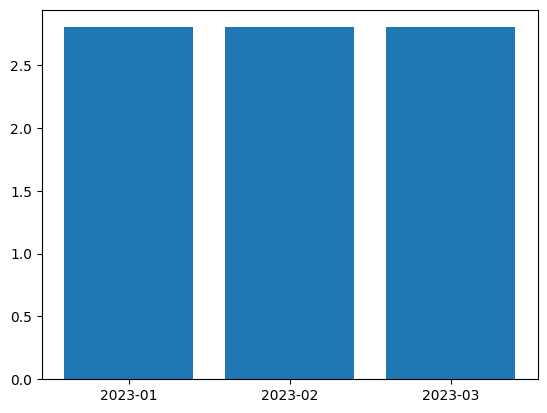


Observation: None
Thought:Hemos creado un gráfico de barras que muestra la evolución de la tasa de paro en Polonia.
Final Answer: El gráfico de barras que muestra la evolución de la tasa de paro en Polonia se ha creado.

> Finished chain.


In [20]:
ask_if_prompt(the_query = "Haz gráfico de barras con la evolución de la tasa de paro en Polonia")
plt.show()

# UI

In [21]:
import gradio as gr
import time

In [23]:


css = """

.gradio-container::before {
    content: "";
    position: absolute;
    top: 0px;
    left: 0;
    right: 0;
    height: 80px;
    z-index: 2;
    position: fixed;
    background: black url(https://www2.deloitte.com/content/dam/assets/logos/deloitte.svg) no-repeat;
    background-size: 182px;
    background-position: 40px;
}

.gradio-container {
  margin-top: 104px !important;
}

:root {
  --body-background-fill: #e8eae9;
  --border-color-accent: #86BC25;
  --color-accent-soft: #E1EEC8;
  --secondary-50: var(--color-accent-soft);
  --input-border-color-focus: var(--border-color-accent);
}

"""



with gr.Blocks(css=css) as demo:
  chatbot = gr.Chatbot()
  msg = gr.Textbox(label="", placeholder="Haz tu pregunta")
  clear = gr.Button("Clear")

  def user(user_message, history):
    return "", history + [[user_message, None]]

  def bot(history):
    pregunta = history[-1][0] + " Contesta en español de forma detallada. "
    bot_message = ask_if_prompt(the_query = pregunta)
    history[-1][1] = ""
    for character in bot_message:
      history[-1][1] += character
      time.sleep(0.002)
      yield history

  msg.submit(user, [msg, chatbot], [msg, chatbot], queue=False).then(
      bot, chatbot, chatbot
  )
  clear.click(lambda: None, None, chatbot, queue=False)

demo.queue(api_open=False)
demo.launch(share=True, show_api=False)

Running on local URL:  http://127.0.0.1:7861

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app
